### Kaggle: HR Analytics Job Change of Data Scientists
#### https://www.kaggle.com/arashnic/hr-analytics-job-change-of-data-scientists

Objective: To predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision.

Elektra Neocleous 3/1/2021

#### Kaggle Context and Content

A company which is active in Big Data and Data Science wants to hire data scientists among people who successfully pass some courses which conduct by the company. Many people signup for their training. Company wants to know which of these candidates are really wants to work for the company after training or looking for a new employment because it helps to reduce the cost and time as well as the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience are in hands from candidates signup and enrollment.

This dataset designed to understand the factors that lead a person to leave current job for HR researches too. By model(s) that uses the current credentials,demographics,experience data you will predict the probability of a candidate to look for a new job or will work for the company, as well as interpreting affected factors on employee decision.

The whole data divided to train and test . Target isn't included in test but the test target values data file is in hands for related tasks. A sample submission correspond to enrollee_id of test set provided too with columns : enrollee _id , target

Note:

* The dataset is imbalanced.
* Most features are categorical (Nominal, Ordinal, Binary), some with high cardinality.
* Missing imputation can be a part of your pipeline as well.

In [219]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import copy
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression

### 0. Import and Explore

In [161]:
aug_test = pd.read_csv("aug_test.csv")
aug_train = pd.read_csv("aug_train.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [162]:
aug_test.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
0,32403,city_41,0.827,Male,Has relevent experience,Full time course,Graduate,STEM,9,<10,NaN,1,21
1,9858,city_103,0.920,Female,Has relevent experience,no_enrollment,Graduate,STEM,5,NaN,Pvt Ltd,1,98
2,31806,city_21,0.624,Male,No relevent experience,no_enrollment,High School,NaN,<1,NaN,Pvt Ltd,never,15
3,27385,city_13,0.827,Male,Has relevent experience,no_enrollment,Masters,STEM,11,10/49,Pvt Ltd,1,39
4,27724,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,10000+,Pvt Ltd,>4,72


In [163]:
aug_test.shape

(2129, 13)

In [164]:
aug_train.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [165]:
aug_train.shape

(19158, 14)

Explore the target to understand the noted imbalance

Target Variable:
<br>

**0 – Not looking for job change
<br>
1 – Looking for a job change**

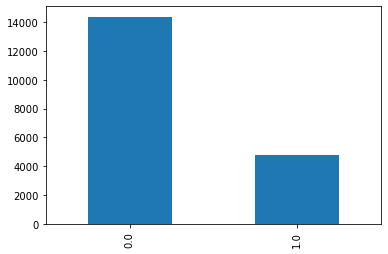

In [166]:
pd.value_counts(aug_train['target']).plot.bar()

### 1. Pre-Process

In [167]:
df_train=copy.deepcopy(aug_train)
df_test=copy.deepcopy(aug_test)

**a. Handling Nulls** <br>
Our length of the dataset is 21k rows, there is a substantial amount of values missing. To handle the this we can drop the rows missing information and still have a substantial amount of rows to model on.

In [168]:
df_train.isna().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [169]:
df_test.isna().sum()

enrollee_id                 0
city                        0
city_development_index      0
gender                    508
relevent_experience         0
enrolled_university        31
education_level            52
major_discipline          312
experience                  5
company_size              622
company_type              634
last_new_job               40
training_hours              0
dtype: int64

In [170]:
df_train = df_train.dropna()
df_test = df_test.dropna()

In [171]:
df_train.shape

(8955, 14)

In [172]:
df_test.shape

(1019, 13)

**b. Encoding categorical data** <br>
Our samples above show that there is categorical data in the columns, we will need to encode these to allow the model to handle the input sufficiently. 

In [173]:
#Objects show us that these are categorical, floats and ints are ok
df_train.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [174]:
#Show all the different unique values in every column so we can get an 
#understanding of what needs to be encoded
for col in df_train:
    print(df_train[col].unique())

[29725   666   402 ... 32313 29754 24576]
['city_40' 'city_162' 'city_46' 'city_103' 'city_61' 'city_114' 'city_159'
 'city_21' 'city_160' 'city_16' 'city_83' 'city_64' 'city_105' 'city_104'
 'city_73' 'city_75' 'city_100' 'city_93' 'city_67' 'city_13' 'city_36'
 'city_71' 'city_57' 'city_65' 'city_11' 'city_136' 'city_97' 'city_50'
 'city_173' 'city_82' 'city_89' 'city_150' 'city_90' 'city_98' 'city_28'
 'city_115' 'city_94' 'city_165' 'city_142' 'city_12' 'city_43' 'city_74'
 'city_102' 'city_116' 'city_99' 'city_23' 'city_138' 'city_45' 'city_41'
 'city_72' 'city_19' 'city_101' 'city_20' 'city_106' 'city_10' 'city_157'
 'city_144' 'city_91' 'city_133' 'city_145' 'city_123' 'city_175'
 'city_128' 'city_167' 'city_84' 'city_54' 'city_126' 'city_81' 'city_176'
 'city_131' 'city_149' 'city_24' 'city_27' 'city_118' 'city_152'
 'city_141' 'city_76' 'city_70' 'city_143' 'city_78' 'city_53' 'city_158'
 'city_2' 'city_77' 'city_117' 'city_120' 'city_9' 'city_39' 'city_80'
 'city_155' 'city_1

In [175]:
#Pick out our object data types, confirmed by the above sample that need to be
#encoded
le = LabelEncoder()
df_train['gender'] = le.fit_transform(df_train['gender'])
df_train['relevent_experience'] = le.fit_transform(df_train['relevent_experience'])
df_train['enrolled_university'] = le.fit_transform(df_train['enrolled_university'])
df_train['education_level'] = le.fit_transform(df_train['education_level'])
df_train['major_discipline'] = le.fit_transform(df_train['major_discipline'])
df_train['experience'] = le.fit_transform(df_train['experience'])
df_train['company_size'] = le.fit_transform(df_train['company_size'])
df_train['company_type'] = le.fit_transform(df_train['company_type'])
df_train['last_new_job'] = le.fit_transform(df_train['last_new_job'])

In [176]:
#Pick out our object data types, confirmed by the above sample that need to be
#encoded
le = LabelEncoder()
df_test['gender'] = le.fit_transform(df_test['gender'])
df_test['relevent_experience'] = le.fit_transform(df_test['relevent_experience'])
df_test['enrolled_university'] = le.fit_transform(df_test['enrolled_university'])
df_test['education_level'] = le.fit_transform(df_test['education_level'])
df_test['major_discipline'] = le.fit_transform(df_test['major_discipline'])
df_test['experience'] = le.fit_transform(df_test['experience'])
df_test['company_size'] = le.fit_transform(df_test['company_size'])
df_test['company_type'] = le.fit_transform(df_test['company_type'])
df_test['last_new_job'] = le.fit_transform(df_test['last_new_job'])

In [177]:
#We can see our encoding worked nicely, giving each unique categorical a numeric number
df_test.head(5)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
3,27385,city_13,0.827,1,0,2,1,5,2,0,5,0,39
4,27724,city_103,0.920,1,0,2,0,5,21,3,5,4,72
11,9272,city_90,0.698,1,0,2,0,5,12,0,5,1,51
12,14249,city_46,0.762,1,0,2,0,5,18,1,3,5,48
16,7865,city_21,0.624,1,0,2,1,5,14,1,5,0,4


In [178]:
df_test.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                      int32
relevent_experience         int32
enrolled_university         int32
education_level             int32
major_discipline            int32
experience                  int32
company_size                int32
company_type                int32
last_new_job                int32
training_hours              int64
dtype: object

In [179]:
#We can make a copy of this dataset without the primary keys of id and city as these aren't features
test = df_test.copy()
train = df_train.copy()
test = test.drop(['enrollee_id','city'],axis=1)
train = train.drop(['enrollee_id','city'],axis=1)

In [180]:
train.head(5)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
1,0.776,1,1,2,0,5,6,4,5,4,47,0.0
4,0.767,1,0,2,1,5,21,4,1,3,8,0.0
7,0.762,1,0,2,0,5,4,7,5,4,18,1.0
8,0.920,1,0,2,0,5,17,4,5,0,46,1.0
11,0.920,1,0,2,0,5,15,6,5,0,108,0.0


In [181]:
test.head(5)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours
3,0.827,1,0,2,1,5,2,0,5,0,39
4,0.920,1,0,2,0,5,21,3,5,4,72
11,0.698,1,0,2,0,5,12,0,5,1,51
12,0.762,1,0,2,0,5,18,1,3,5,48
16,0.624,1,0,2,1,5,14,1,5,0,4


**c. Resolve the data imbalance** <br>
We learnt above between our targets our 0's highly outweigh our 1's. This is common in datasets as our 1's can be a smaller population of unique attributes. We can solver this by either over or under sampling the populations: <br>
* Undersampling would decrease the proportion of your majority class until the number is similar to the minority class.
* Oversampling would resample the minority class proportion following the majority class proportion. e.g. SMOTE, repetition or bootstrapping.

**i. Smote - Synthetic Minority Oversampling Technique** <br>
The SMOTE algorithm can be broken down into four steps: <br>

* Randomly pick a point from the minority class.
* Compute the k-nearest neighbors (for some pre-specified k) for this point.
* Add k new points somewhere between the chosen point and each of its neighbors.

In [217]:
#Seperate the target column from the training dataset and place them into their
#respective x and y so we can apply the technique to them

def smote():
    X=train.drop(columns=['target']).values
    y=train['target'].values
    print('Before resampled dataset shape %s' % Counter(y))
    
    #Apply smote then create our test and train split
    smote = SMOTE(random_state=0)
    X, y = smote.fit_sample(X, y) 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=2)
    print('Resampled dataset shape %s' % Counter(y))
    
    #Creating a new Oversampling Data Frame to see the output as the train test split makes it an array
    df_oversampler = pd.DataFrame(X, columns = ['city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours'])
    df_target = pd.DataFrame(y, columns = ['target'])
    
    df_oversampler_concat = pd.merge(df_oversampler, df_target, left_index=True, right_index=True)
    
    cols_to_plot = ['city_development_index','gender','relevent_experience']
    
    #plot the new dataframe with the over sampled target, lets compare the spread to a few features to see the 1's decrease in size
    fig, ax = plt.subplots(nrows=len(cols_to_plot), ncols=1, figsize=(8,8))
    for i, col in enumerate(cols_to_plot):
        plt.subplot(ax[i])
        sns.scatterplot(x=df_oversampler_concat[col], y=df_oversampler_concat['target'], hue = df_oversampler_concat['target'])
        plt.ylabel(col)
        plt.tight_layout()

    return X_train, X_test, y_train, y_test, df_oversampler

Before resampled dataset shape Counter({0.0: 7472, 1.0: 1483})
Resampled dataset shape Counter({0.0: 7472, 1.0: 7472})


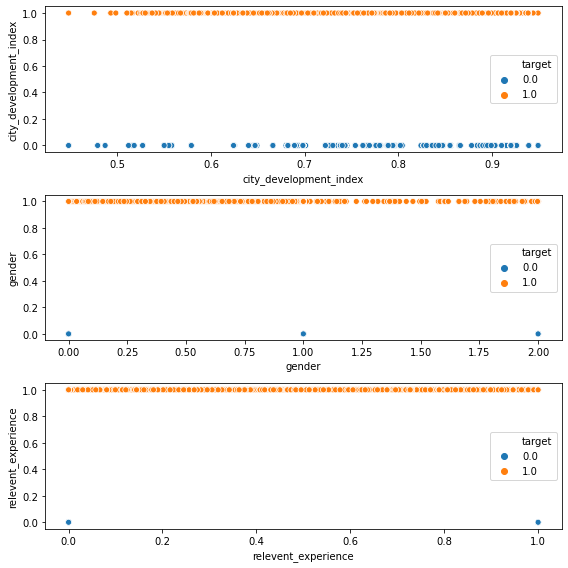

In [218]:
X_train, X_test, y_train, y_test, df_oversampler = smote()

### 2. Model

Play around with a few different models, tune different hyperparametres to see which one works well

**a. Logistic Regression** <br>
Logistic regression models the probabilities for classification problems with two possible outcomes, 0 or 1. It uses logarithm of the odds for the value labelled as 1 to calculate the probabilities and predict the occurance of the event being this label. Logistic regression is statistical, relatively fast and uncomplicated for binary classification problems. 

In [231]:
logistic = LogisticRegression(max_iter=10000) #max_iter increased due to convergence warning
logistic.fit(X_train,y_train)

LogisticRegression(max_iter=10000)

**Accuracy**<br>
Accuracy = (TP+TN)/(TP+FP+FN+TN)<br>
Accuracy is a valid choice of evaluation for classification problems which are well balanced and not skewed or No class imbalance. We know we had an imbalanced dataset which was fixed in pre-processing so this score would be higher if performed on an un-preproccessed dataset

In [250]:
#Accuracy or AUC calc
# Use score method to get accuracy of model
score = logistic.score(X_test,y_test)
print('Accuracy on test set is : ',round(score, 2))

Accuracy on test set is :  0.74


**Confusion Matrix**<br>
A table that clearly identifies the counts of True Positives, False Positives, False Negatives and True Negatives. From these raw numbers we can calculate further metrics to grasp the strengths and weaknesses of the model.

In [262]:
#Make predictions on entire test data
predictions = logistic.predict(X_test) 

#Prepare a confusion matrix from the predictions on the entire data set
#Confusion matrix positionings: https://glassboxmedicine.files.wordpress.com/2019/02/confusion-matrix.png?w=816
cm = metrics.confusion_matrix(y_test, predictions)
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[0][1]
print('True Positive: %.f, False Positive: %.f, False Negative: %.f, True Negative %.f' % (tp, fp, fn, tn))

True Positive: 1977, False Positive: 477, False Negative: 819, True Negative 477


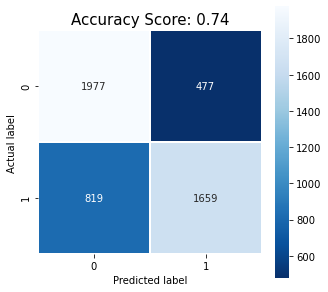

In [248]:
#Annotate all of our information into a plot
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);

**Area under the curve (ROC)** <br>
A ROC curve is constructed by plotting the true positive rate (TPR) against the false positive rate (FPR). The true positive rate is the proportion of observations that were correctly predicted to be positive out of all positive observations (TP/(TP + FN)). 

*Interpretation* <br>
Curves closer to the top left of the graph, indicate a better performance. Closer the curve comes along the red dotted line, the less accurate the test. We see below that we did well, there may be some room for improvement for our 477 false positives and 819 false negatives.

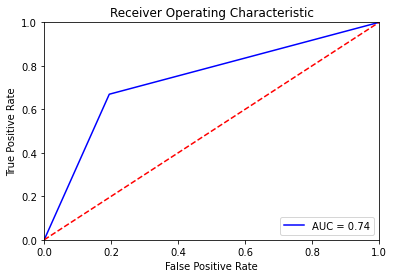

In [247]:
#Area under the curve
fpr, tpr, threshold = metrics.roc_curve(y_test, predictions)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**GINI Coefficient** <br>
The gini measures inequality among values of a variable and the overall performance of the classifier. It is good when used on imbalanced datasets, a score closer to 1 would be better but depending on the classifier there will be limitations on how close to 1 it can get. We could do better here, 47% is average.

In [251]:
#GINI function sourced from https://www.kaggle.com/batzner/gini-coefficient-an-intuitive-explanation
def gini(actual, pred):
    assert (len(actual) == len(pred))
    all = np.asarray(np.c_[actual, pred, np.arange(len(actual))], dtype=np.float)
    all = all[np.lexsort((all[:, 2], -1 * all[:, 1]))]
    totalLosses = all[:, 0].sum()
    giniSum = all[:, 0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)


def gini_normalized(actual, pred):
    return gini(actual, pred) / gini(actual, actual)

In [263]:
gini_predictions = gini(y_test, predictions)
gini_max = gini(y_test, y_test)
ngini= gini_normalized(y_test, predictions)
print('Gini: %.3f, Max. Gini: %.3f, Normalized Gini (Metric Used): %.3f' % (gini_predictions, gini_max, ngini))

Gini: 0.119, Max. Gini: 0.249, Normalized Gini (Metric Used): 0.476


**b. Decision Tree** <br>

In [222]:
from sklearn.tree import DecisionTreeClass ifier
tree = DecisionTreeClassifier()
tree.fit(X_train,y_train)
print('Accuracy on test set is ', tree.score(X_test,y_test))

Accuracy on test set is  0.8262368207623683


**c. Support Vector Machine** <br>

In [223]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(X_train,y_train)
print('Accuracy on test set is ', svc.score(X_test,y_test))

Accuracy on test set is  0.5411597729115978


**d. Gradient Boosting Classifier** <br>

In [224]:
from sklearn.ensemble import GradientBoostingClassifier
boost = GradientBoostingClassifier(n_estimators=200)
boost.fit(X_train,y_train)
print('accuracy on test set : ',boost.score(X_test,y_test))

accuracy on test set :  0.9022708840227088


**e. Random Forest** <br>

In [225]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
forest.fit(X_train,y_train)
print('accuracy on test set : ',forest.score(X_test,y_test))

accuracy on test set :  0.8959854014598541
